# Parameter fitting
There exist several methods for fitting parameters to a model in Julia. Here, we demonstrate how Catalyst combines with the PEtab.jl package to fit the parameters of a simple ODE to data.

For our example we will use a simple catalysis network, where an enzyme (*E*) turns a substrate (*S*) into a product (*P*):

In [1]:
using Catalyst, PEtab
rn = @reaction_network begin
    kB, S + E --> SE
    kD, SE --> S + E
    kP, SE --> P + E
end

Model ##ReactionSystem#230
States (4):
  S(t)
  E(t)
  SE(t)
  P(t)
Parameters (3):
  kB
  kD
  kP

We will create a synthetic data set to demosntrate the fitting process on:

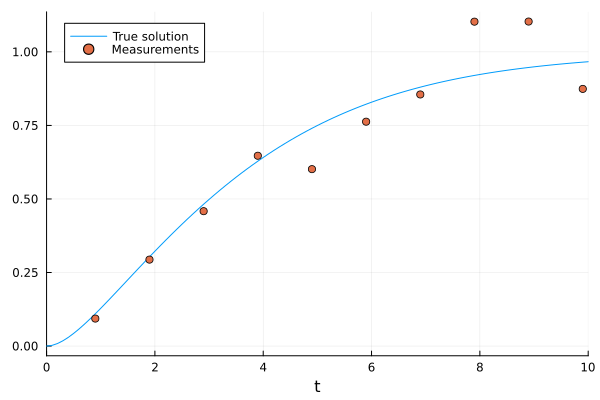

In [2]:
# Define initial conditions and parameters.
u0 = [:S => 1.0, :E => 1.0, :SE => 0.0, :P => 0.0]
p_true = [:kB => 1.0, :kD => 0.1, :kP => 0.5]

# Generate synthetic data.
using OrdinaryDiffEq, Random
oprob = ODEProblem(rn, u0, (0.0, 10.0), p_true)
sol = solve(oprob, Tsit5(); saveat=0.1)
data = (0.8 .+ 0.4*rand(10)) .* sol[:P][10:10:end]

# Plots the true solutions and the (synthetic data) measurements.
using Plots
plot(sol; idxs=:P, label="True solution")
plot!(sol.t[10:10:end], data; label="Measurements", seriestype=:scatter)

Generally, PEtab takes five different inputs to define an optimisation problem (the minimiser of which generates a fitted parameter set):
1. **Model**: The model which we want to fit to the data (a `ReactionSystem`).
2. **Observables**: The possible observables that can be measured (a `Dict{String,PEtabObservable}`).
3. **Estimation parameters**: The parameters which we want to fit to the data (a `Vector{PEtabParameter}`). 
4. **Experimental (or simulation) conditions**: The simulations (each corresponding to a potential experiment) carried out during each step of the optimisation process (a `Dict{String,Dict{Symbol,Float64}}`).
5. **Measurements**: The measurements to which the model is fitted (a `DataFrame`). 

### Observables
The observables define the quantities that we may measure in our experiments. Typically, each corresponds to a single species, however, [more complicated observables are possible](@ref petab_observables_observables). For each observable, we also need a noise formula, defining the uncertainty in the measurement. By default, PEtab assumes normally distributed noise, with a mean equal to the true value and a standard deviation which we have to define. It is also possible to use [more advanced noise formulas](@ref petab_observables_noise_formula).

In our example, we only have a single possible observable, the `P` species. We will assume that the noise is normally distributed with a standard deviation `0.5` (in our case this is not true, however, typically the noise distribution is unknown). If the strength of the measurement noise is unknown it can also be estimated along with the other parameters. We combine this information in a `PEtabObservable` struct (to access the `P` species we must use `@unpack`). Finally, we store all our observables in a dictionary, giving each an id tag (which is later used in the measurements input).


In [3]:
@unpack P = rn
obs_P = PEtabObservable(P, 0.5)
observables = Dict("obs_P" => obs_P);

### Parameters
Each parameter of the system can either be
1. Known.
2. Depend on experimental/simulated conditions. 
3. Be an unknown we wish to fit to data.

In our case, we wish to fit all three system parameters (*kB*, *kD*, and *kP*). For each, we create a single `PEtabParameter`, and then gather these into a single vector.

In [4]:
par_kB = PEtabParameter(:kB)
par_kD = PEtabParameter(:kD)
par_kP = PEtabParameter(:kP)
params = [par_kB, par_kD, par_kP]

3-element Vector{PEtabParameter}:
 PEtabParameter kB. Estimated on log10-scale with bounds [1.0e-03, 1.0e+03]
 PEtabParameter kD. Estimated on log10-scale with bounds [1.0e-03, 1.0e+03]
 PEtabParameter kP. Estimated on log10-scale with bounds [1.0e-03, 1.0e+03]

Additional options, such as specifying bounds or prior distributions, is also available.

### Measurements
Finally, we need to define the system measurements to which the parameters will be fitted. Each measurement combines:
1. The observable which is observed (here we use the id tag defined in the `observables` dictionary).
2. The time point of the measurement.
3. The measured value.


Measurements are provided in a `DataFrame` where each row corresponds to a measurement. The values are provided in the `obs_id`, `time`, and `measurement` columns. 

For more advanced parameter fitting problems (depending on several different experiments), a fourth column, `simulation_id`, also exist. For model with pre-equilibration (the model should be simulated to a steady-state prior to being matched against data) a fifth column `pre_eq_id` also exist.

In [5]:
using DataFrames
measurements = DataFrame(obs_id="obs_P", time=sol.t[10:10:end], measurement=data)

Row,obs_id,time,measurement
,String,Float64,Float64
1,obs_P,0.9,0.093409
2,obs_P,1.9,0.293825
3,obs_P,2.9,0.458441
4,obs_P,3.9,0.646885
5,obs_P,4.9,0.601329
6,obs_P,5.9,0.76264
7,obs_P,6.9,0.855165
8,obs_P,7.9,1.10261
9,obs_P,8.9,1.10304


### Creating a PEtabModel
Finally, we combine all inputs in a single `PEtabModel`. To it, we also pass the initial conditions of our simulations (using the `state_map` argument). 


In [6]:
petab_model = PEtabModel(rn, observables, measurements, params; state_map=u0)

PEtabModel for model ReactionSystemModel. ODE-system has 4 states and 3 parameters.

### Fitting parameters
We are now able to fit our model to the data. First, we create a `PEtabODEProblem`, and then we use it as input to the `calibrate_model` function. This requires some optimization package, here we use Optim.jl.

When creating an `ODEProblem` we can choose ODE solver, as well as between several gradient methods and Hessian computation methods. If not chosen, defaults adapted to the problem size are used, as here where the `Rodas5P` solver is used, and both the gradient and Hessian are computed with ForwardDiff

In [7]:
petab_problem = PEtabODEProblem(petab_model; verbose=false)

using Optim
p0 = generate_startguesses(petab_problem, 1)
res = calibrate_model(petab_problem, p0, IPNewton())

PEtabOptimisationResult
--------- Summary ---------
min(f)                = 2.43e+00
Parameters esimtated  = 3
Optimiser iterations  = 29
Run time              = 9.8e-01s
Optimiser algorithm   = Optim_IPNewton


We can now simulate our model for the fitted parameter set, and compare the result to the measurements and true solution.

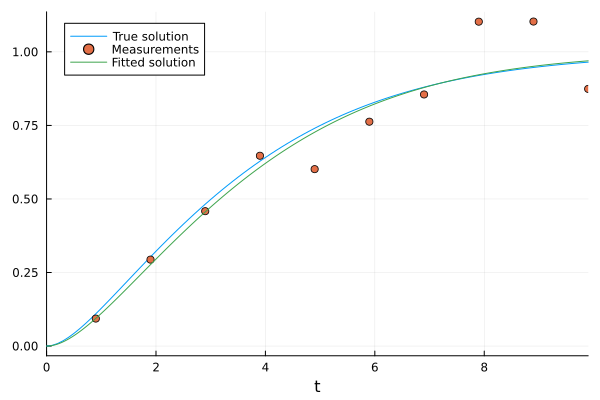

In [8]:
sol = get_odesol(res.xmin, petab_problem)
plot!(sol; idxs=4, label="Fitted solution")

(It should be noted that PEtab.jl contain a lot more features than what have been demonstrate here, for a full list, see that package's documentation)